<a href="https://colab.research.google.com/github/manthan-mehta/ImageClassification/blob/master/FullyConnected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def load_cifar10(cifar10_folder_path,batch_id):
  import pickle
  with open(cifar10_folder_path + '/data_batch_' +str(batch_id),'rb') as fo:
    dict = pickle.load(fo,encoding='latin1')
  return dict

In [7]:
train = None
Y_train = []
for i in range(1,6):
  dict1 = load_cifar10('/content',1)
  if i==1:
    train = dict1['data']
  else:
    train = np.vstack((train,dict1['data']))
  Y_train += dict1['labels']

X_train = train.reshape((len(train), 3, 32, 32)).transpose(0, 2, 3, 1)
Y_train = np.asarray(Y_train)
print(X_train.shape)

(50000, 32, 32, 3)


In [8]:
import pickle
with open('/content/test_batch','rb') as fo:
    test_data = pickle.load(fo,encoding='latin1')
X_test = test_data['data'].reshape((len(test_data['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
Y_test = np.asarray(test_data['labels'])

num_training = 49000
num_validation = 1000
num_test = 1000
# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
Y_val = Y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
Y_train = Y_train[mask]

# print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)


Training data shape:  (49000, 32, 32, 3)
Validation data shape:  (1000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


In [0]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [0]:
def fully_forward(x,w,b):
  out = None
  dim_size = x[0].shape
  X = x.reshape(x.shape[0],np.prod(dim_size))
  #print(X.shape,w.shape) 
  out = X.dot(w)+b
  cache = (x,w,b)
  return out,cache

In [11]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = fully_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


In [0]:
def fully_backward(dout,cache):
  x, w, b = cache
  dx, dw, db = None, None, None
  dim_shape = np.prod(x[0].shape)
  N = x.shape[0]
  X = x.reshape(N, dim_shape)

  dx = dout.dot(w.T)
  dx = dx.reshape(x.shape)

  dw = X.T.dot(dout)
  db = dout.sum(axis=0)

  return dx,dw,db

In [0]:
def relu_forward(x):
  out = None
  out = np.maximum(0,x)
  cache = x
  return out,cache

In [0]:
def relu_backward(dout,cache):
  dx,x = None,cache
  dx = dout * (x > 0)
  return dx

In [0]:
def fully_relu_forward(x,w,b):
  a,f_cache = fully_forward(x,w,b)
  out,relu_cache = relu_forward(a)
  cache = (f_cache,relu_cache)
  return out,cache

In [0]:
def fully_relu_backward(dout,cache):
  f_cache,relu_cache = cache
  #print(dout.shape,relu_cache.shape)
  da = relu_backward(dout,relu_cache)
  dx,dw,db = fully_backward(da,f_cache)
  return dx,dw,db

In [0]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.
    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C
    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

In [0]:
class TwoLayerNet(object):
  def __init__(self,input_dim=3*32*32,hidden_dim=100,num_classes=10,weight_scale=1e-3,reg=0.0):
    self.params = {}
    self.reg = reg
    self.params['W1'] = weight_scale*np.random.randn(input_dim,hidden_dim)
    self.params['W2'] = weight_scale*np.random.randn(hidden_dim,num_classes)
    self.params['b1'] = np.zeros(hidden_dim)
    self.params['b2'] = np.zeros(num_classes)

  def loss(self,x,y=None):
    scores = None
    W1 = self.params['W1']
    W2 = self.params['W2']
    b1 = self.params['b1']
    b2 = self.params['b2']
    x2,relu_cache = fully_relu_forward(x,W1,b1)
    scores,relu2_cache = fully_relu_forward(x2,W2,b2)

    if y is None:
      return scores
    loss,grads = 0,{}
    loss, softmax_grad = softmax_loss(scores, y)
    loss += 0.5 * self.reg * ( np.sum(W1 * W1) + np.sum(W2 * W2) )

    # calculate gradient
    dx2, dw2, db2 = fully_relu_backward(softmax_grad, relu2_cache)
    dx, dw, db = fully_relu_backward(dx2, relu_cache)
    grads['W2'] = dw2 + self.reg * W2
    grads['b2'] = db2
    grads['W1'] = dw + self.reg * W1
    grads['b1'] = db
    return loss,grads

In [19]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
print(X.shape)
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
print(abs(loss - correct_loss))

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
print(abs(loss - correct_loss))


Testing initialization ... 
Testing test-time forward pass ... 
(3, 5)
Testing training loss (no regularization)
4.6100900874535e-12
3.858247055177344e-11


In [0]:
class Solver(object):
  def __init__(self,model,X_train,Y_train,X_val,Y_val,**kwargs):
    self.model = model
    self.X_train = X_train
    self.Y_train = Y_train
    self.X_val = X_val
    self.Y_val = Y_val
    self.update_rule = kwargs.pop('update_rule', 'sgd')
    self.optim_config = kwargs.pop('optim_config', {})
    self.lr_decay = kwargs.pop('lr_decay', 1.0)
    self.batch_size = kwargs.pop('batch_size', 100)
    self.num_epochs = kwargs.pop('num_epochs', 10)
    self.num_train_samples = kwargs.pop('num_train_samples', 1000)
    self.num_val_samples = kwargs.pop('num_val_samples', None)
    self.checkpoint_name = kwargs.pop('checkpoint_name', None)
    self.print_every = kwargs.pop('print_every', 10)
    self.verbose = kwargs.pop('verbose', True)
    #self.update_rule = getattr(optim, self.update_rule)
    self._reset()

  def _reset(self):
    self.epoch = 0
    self.best_val_acc = 0
    self.best_params = {}
    self.loss_history = []
    self.train_acc_history = []
    self.val_acc_history = []

    # Make a deep copy of the optim_config for each parameter
    self.optim_configs = {}
    for p in self.model.params:
      d = {k: v for k, v in self.optim_config.items()}
      self.optim_configs[p] = d

  def sgd11(w, dw, config=None):

    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config

  def _step(self):
    num_train = self.X_train.shape[0]
    batch_mask = np.random.choice(num_train, self.batch_size)
    X_batch = self.X_train[batch_mask]
    y_batch = self.Y_train[batch_mask]

    loss, grads = self.model.loss(X_batch, y_batch)
    self.loss_history.append(loss)

    # Perform a parameter update
    for p, w in self.model.params.items():
      dw = grads[p]
      config = self.optim_configs[p]
      #next_w, next_config = self.sgd11(w, dw, config)
      next_w = w - config['learning_rate']*dw
      next_config = config
      self.model.params[p] = next_w
      self.optim_configs[p] = next_config

  def _save_checkpoint(self):
    if self.checkpoint_name is None: return
    checkpoint = {
          'model': self.model,
          'update_rule': self.update_rule,
          'lr_decay': self.lr_decay,
          'optim_config': self.optim_config,
          'batch_size': self.batch_size,
          'num_train_samples': self.num_train_samples,
          'num_val_samples': self.num_val_samples,
          'epoch': self.epoch,
          'loss_history': self.loss_history,
          'train_acc_history': self.train_acc_history,
          'val_acc_history': self.val_acc_history,
    }
    filename = '%s_epoch_%d.pkl' % (self.checkpoint_name, self.epoch)
    if self.verbose:
        print('Saving checkpoint to "%s"' % filename)
    with open(filename, 'wb') as f:
        pickle.dump(checkpoint, f)

  def check_accuracy(self,X,y,num_samples=None,batch_size=100) :
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
      mask = np.random.choice(N, num_samples)
      N = num_samples
      X = X[mask]
      y = y[mask]

    num_batches = N // batch_size
    if N % batch_size != 0:
      num_batches += 1
    y_pred = []
    for i in range(num_batches):
      start = i * batch_size
      end = (i + 1) * batch_size
      scores = self.model.loss(X[start:end])
      y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)
    return acc

  def train(self):
    num_train = self.X_train.shape[0]
    iterations_epoch = max(num_train // self.batch_size , 1)
    num_iterations = self.num_epochs * iterations_epoch

    for t in range(num_iterations):
      self._step()

      if self.verbose and t % self.print_every == 0:
        print('(Iteration %d / %d) loss: %f' % (
              t + 1, num_iterations, self.loss_history[-1]))
      
      #check if epoch is over and if its over then decay learning rate and increment num of epoch
      epoch_end = (t + 1) % iterations_epoch == 0
      if epoch_end:
        self.epoch += 1
        for k in self.optim_configs:
          self.optim_configs[k]['learning_rate'] *= self.lr_decay
      
      # Check train and val accuracy on the first iteration, the last
      # iteration, and at the end of each epoch.
      first_it = (t == 0)
      last_it = (t == num_iterations - 1)
      if first_it or last_it or epoch_end:
        train_acc = self.check_accuracy(self.X_train, self.Y_train,
            num_samples=self.num_train_samples)
        val_acc = self.check_accuracy(self.X_val, self.Y_val,
            num_samples=self.num_val_samples)
        self.train_acc_history.append(train_acc)
        self.val_acc_history.append(val_acc)
        self._save_checkpoint()

        if self.verbose:
          print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                self.epoch, self.num_epochs, train_acc, val_acc))

        # Keep track of the best model
        if val_acc > self.best_val_acc:
          self.best_val_acc = val_acc
          self.best_params = {}
          for k, v in self.model.params.items():
            self.best_params[k] = v.copy()

    # At the end of training swap the best params into the model
    self.model.params = self.best_params

In [21]:
model = TwoLayerNet()
solver = None
best_val = -1
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden
for i in range(20):
    lr, reg, hidden_size = generate_random_hyperparams(-4,-2, -7, -4, 10, 200)
    model = TwoLayerNet(hidden_dim = hidden_size, reg= reg)
    cur_solver = Solver(model, X_train,Y_train,X_val,Y_val, update_rule='sgd', optim_config={'learning_rate':lr}, 
                        lr_decay=0.95, num_epochs=5,batch_size=200, print_every=-1, verbose=False)
    cur_solver.train()
    val_accuracy = cur_solver.best_val_acc
    if best_val < val_accuracy:
        best_val = val_accuracy
        solver = cur_solver
    # Print results
    print('lr %e reg %e hid %d  val accuracy: %f' % (
                lr, reg, hidden_size, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)

lr 5.547653e-03 reg 7.123358e-07 hid 152  val accuracy: 0.116000
lr 3.304700e-04 reg 6.890565e-05 hid 126  val accuracy: 0.390000
lr 5.063610e-03 reg 1.486770e-07 hid 118  val accuracy: 0.116000
lr 1.794447e-04 reg 4.769166e-06 hid 38  val accuracy: 0.355000
lr 9.235702e-03 reg 1.392248e-06 hid 22  val accuracy: 0.107000
lr 3.801213e-04 reg 2.235742e-07 hid 76  val accuracy: 0.422000
lr 5.206455e-03 reg 3.586337e-07 hid 92  val accuracy: 0.150000
lr 1.061826e-04 reg 2.714656e-05 hid 88  val accuracy: 0.332000
lr 7.271861e-03 reg 7.792737e-06 hid 134  val accuracy: 0.107000
lr 5.377205e-04 reg 6.559638e-06 hid 56  val accuracy: 0.423000
lr 2.200057e-03 reg 4.408483e-07 hid 141  val accuracy: 0.165000
lr 5.204039e-03 reg 5.388462e-05 hid 86  val accuracy: 0.128000
lr 7.368653e-03 reg 7.769144e-05 hid 178  val accuracy: 0.140000
lr 6.771452e-04 reg 1.212714e-05 hid 88  val accuracy: 0.394000
lr 1.177248e-04 reg 1.992240e-05 hid 35  val accuracy: 0.308000
lr 2.015070e-04 reg 4.306539e-05 h

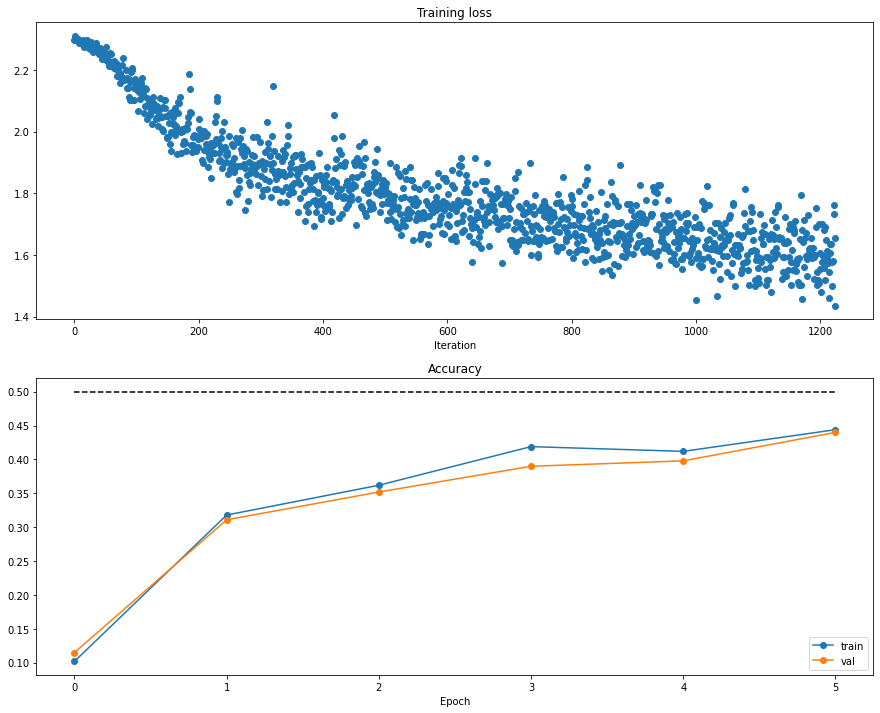

In [22]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [0]:
class FullyConnected(object):
  def __init__(self,hidden_dims,input_dim = 3*32*32,num_classes = 10,dropout = 1,
               normalization = None,reg = 0.0,weight_scale = 1e-2,dtype = np.float32,seed = None):
    self.normalization = normalization
    self.use_dropout = dropout != 1
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.params = {}
    
    layers_dims = np.hstack([input_dim, hidden_dims, num_classes])
    for i in range(self.num_layers):
      self.params['W'+str(i+1)] = weight_scale*np.random.randn(layers_dims[i],layers_dims[i+1])
      self.params['b'+str(i+1)] = np.zeros(layers_dims[i+1])
    
    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)
  
  def loss(self, X, y = None):
    